In [89]:
#Import required packages
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
#Load MNIST dataset
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


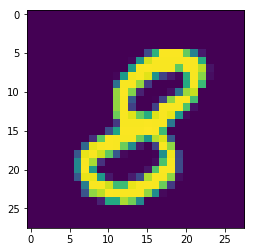

In [90]:
plt.imshow(mnist.train.images[5].reshape([28, 28]))
print(mnist.train.labels[5])

In [91]:
n_tr = mnist.train.images.shape[0]# number of training samples
n_ts = mnist.test.images.shape[0]#number of testing samples
n_pixel = mnist.train.images.shape[1]

## Batch Nomalization For CNN Model

In [92]:
#Below code was referred to http://danijar.com/structuring-your-tensorflow-models/
import functools
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.

    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__#Get function name
    name = scope or function.__name__
    @property
    @functools.wraps(function)#Keep the original function
    def decorator(self):
        if not hasattr(self, attribute):#If the attribute not exist
            with tf.variable_scope(name, *args, **kwargs):#Add scope name
                setattr(self, attribute, function(self))
        return getattr(self, attribute)#otherwise return the attribute
    return decorator

In [93]:
#定义一个MNIST分类的基类
class MnistModel:
    '''Define a basic model for MNIST image classification, the model
    Provides graph structure of tensorflow'''
    
    def __init__(self, input_holder, target_holder, is_training, keep_prob):
        self.input_holder = input_holder
        self.target_holder = target_holder
        self.is_training = is_training
        self.num_pixel = 784
        self.num_class = 10
        self.keep_prob = keep_prob
        self.prediction
        self.optimize
        self.accuracy
        print('Model Initialized!') 
    
    @define_scope(initializer=tf.contrib.slim.xavier_initializer())
    def prediction(self):
        return None
    
    @define_scope
    def loss(self):
        return None
    
    @define_scope
    def optimize(self):
        return None
    
    @define_scope
    def accuracy(self):
        return None
    

Reference:https://github.com/ry/tensorflow-resnet/blob/master/resnet.py
https://gist.github.com/tomokishii/0ce3bdac1588b5cca9fa5fbdf6e1c412
https://r2rt.com/implementing-batch-normalization-in-tensorflow.html

In [104]:
from tensorflow.python.training import moving_averages
from tensorflow.python.ops import control_flow_ops
class CnnMnistModel(MnistModel):
    #重构某些函数
    
    @define_scope(initializer=tf.contrib.slim.xavier_initializer())
    def prediction(self):
        #定义权重和偏置参数变量
        logits = self.cnnLayer
        return tf.nn.softmax(logits)

    @define_scope
    def optimize(self):
        cross_entropy = self.loss
        optimizer = tf.train.AdamOptimizer(1e-4)
        return optimizer.minimize(cross_entropy)
    
    @define_scope
    def loss(self):
        pred = self.prediction
        pred = tf.clip_by_value(pred, 1e-10, 1)
        cross_entropy = -tf.reduce_mean(self.target_holder*
                                       tf.log(pred))
        return cross_entropy

    @define_scope
    def accuracy(self):
        correct_prediction = tf.equal(tf.argmax(self.target_holder,1), 
                                      tf.argmax(self.prediction,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        return accuracy
    
    @define_scope
    def correct_num(self):
        '''Count correct predictions for testing part'''
        #labels = tf.one_hot(self.label_holder, self.num_class, 1, 0)
        #correct_prediction = tf.equal(tf.argmax(self.target_holder,1), 
                                    #tf.argmax(self.prediction,1))
        #eval_correct = tf.reduce_sum(tf.cast(correct_prediction, "float"))
        logits = self.cnnLayer
        labels = tf.argmax(self.target_holder, 1)
        eval_correct=tf.nn.in_top_k(logits,labels,1)
        return eval_correct
    
    @define_scope
    def cnnLayer(self):
        #Note, we need to share weights here, so variable_scope 
        #should be specified
        x_image = tf.reshape(self.input_holder, [-1,28,28,1])
        #First Conv
        with tf.variable_scope('hidden1'):
            kernel_shape, bias_shape = [5, 5, 1, 32], [32] 
            h_pool1 = self.conv_relu_bn_pool(x_image, kernel_shape, bias_shape)
            #Second variable_scope
        with tf.variable_scope('hidden2'):
            kernel_shape, bias_shape = [5, 5, 32, 64], [64] 
            h_pool2 = self.conv_relu_bn_pool(h_pool1, kernel_shape, bias_shape)
    
        #Fully Connected Layer
        with tf.variable_scope('fully_conn'):
            W_fc1 = self._get_variable(name='weights', shape=[7 * 7 * 64, 1024])
            b_fc1 = self._get_variable(name='bias', shape=[1024])
            h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        #Dropout, to prevent against overfitting      
        h_fc1_drop = tf.nn.dropout(h_fc1, self.keep_prob)
        #Softmax Layer
        with tf.variable_scope('softmax_layers'):
            W_fc2 = self._get_variable(name='weights', shape=[1024, 10])
            b_fc2 = self._get_variable(name='bias', shape=[10])
            logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
            
        return logits
    
    #卷积函数
    def conv2d(self, x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    
    #池化函数
    def max_pool_2x2(self, x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1], padding='SAME')

    

    def _get_variable(self, name,
                  shape,
                  initializer=None,
                  weight_decay=0.0,
                  trainable=True):
        "A little wrapper around tf.get_variable to do weight decay and add to"
        "resnet collection"   
        return tf.get_variable(name,
                           shape=shape,
                           initializer=initializer,
                           dtype=tf.float32,
                           trainable=trainable)

    def conv_relu_bn_pool(self, x, kernel_shape, bias_shape):
        # Create variable named "weights".
        initializer = tf.random_uniform_initializer(-0.01, 0.01)
        weights = self._get_variable('conv_weights', kernel_shape, 
                                     initializer=initializer)
        # Create variable named "biases".
        biases = self._get_variable('conv_bias', bias_shape, 
                                     initializer=initializer)
        conv = self.conv2d(x, weights)
        bn = self.batch_normalization(conv+ biases)
        relu = tf.nn.relu(bn)
        pool = self.max_pool_2x2(relu)
        return pool
    


    def batch_normalization(self, x):
        x_shape = x.get_shape()
        params_shape = x_shape[-1:]
        axis = list(range(len(x_shape) - 1))
        #The bias for batch normalization
        beta = self._get_variable('beta',
                             params_shape,
                             initializer=tf.zeros_initializer)
        #The scale of batch normalization
        gamma = self._get_variable('gamma',
                              params_shape,
                              initializer=tf.ones_initializer)
        #Record moving average for testing
        moving_mean = self._get_variable('moving_mean',
                                    params_shape,
                                    initializer=tf.zeros_initializer,
                                    trainable=False)
        #Record moving average for testing
        moving_variance = self._get_variable('moving_variance',
                                    params_shape,
                                    initializer=tf.ones_initializer,
                                    trainable=False)  
        # These ops will only be preformed when training.
        mean, variance = tf.nn.moments(x, axis)
        #Update moving averages
        update_moving_mean = moving_averages.assign_moving_average(moving_mean,
                                                               mean, 0.9997)
        update_moving_variance = moving_averages.assign_moving_average(moving_variance, 
                                                                       variance, 0.9997)
      
        if self.is_training:
            mean, variance = mean, variance
        else:
            mean, variance = moving_mean, moving_variance 
        x = tf.nn.batch_normalization(x, mean, variance, beta, gamma, 0.001)
        return x

In [108]:
batch_size = 64
num_pixel = 784
num_class = 10
tf.reset_default_graph() 
graph = tf.Graph()

with graph.as_default():
    #定义feed数据
    #定义输入数据
    input_holder = tf.placeholder(tf.float32, [None, num_pixel])
    #输入数据对应标签
    target_holder = tf.placeholder(tf.float32, [None,num_class])
    initializer = tf.random_uniform_initializer(-0.01, 0.01)
    with tf.variable_scope('CNN', reuse=None, initializer=initializer):
        train_model = CnnMnistModel(input_holder, target_holder, True, 0.5)
    with tf.variable_scope('CNN', reuse=True, initializer=initializer):
        test_model = CnnMnistModel(input_holder, target_holder, False, 1)

Model Initialized!
Model Initialized!


In [109]:
epochs = 1
batch_size = 64
num_steps = int(n_tr/batch_size)
#Create a session
with tf.Session(graph=graph) as sess:
    #Initialize variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    #Train the data
    for _ in range(epochs):
        for step in range(num_steps):
            batch_data, batch_labels = mnist.train.next_batch(batch_size)
            feed_dict = {input_holder : batch_data, target_holder: batch_labels}
            #Train
            _, l, a = sess.run([train_model.optimize, train_model.loss, train_model.accuracy], feed_dict=feed_dict)
            if step%500 == 0:
                print('Loss:{:.5f}'.format(l), 'Accuracy:{:.5f}'.format(a))
    
    count = 0    
    for _ in range(200):
        batch_data, batch_labels = mnist.test.next_batch(50)
        feed_dict = {input_holder : batch_data, target_holder: batch_labels}
        cp = sess.run(test_model.correct_num, feed_dict=feed_dict)
        count += np.sum(cp)
    print("Testing Accuracy：", count/n_ts)


Loss:0.28169 Accuracy:0.06250
Loss:0.00956 Accuracy:0.95312
Testing Accuracy： 0.0997
